In [2]:
import os
import random
import time

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import chess
import chess.svg
import chess.engine

from IPython.display import SVG, display

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier


In [3]:
class Individual:
    niz = []
    def __init__(self):
        self.code = self.generateCode()
        self.fitness = self.calcFitness()
        
    def generateCode(self):
        # generate 64 integers - one for each chess position
        c = np.zeros(64, dtype=np.uint8)
        for i in range(64):
            #integers will be between 0 and 12, representing an empty square or a piece.
            c[i] = random.randrange(13) 
        return c
    
    def calcFitness(self):
        board = self.array_to_board(self.code)

        if len(board.piece_map()) <= 9:
            penalty = 1 / len(board.piece_map())
        else:
            penalty = len(board.piece_map()) * 0.5

        # Penalize invalid boards heavily
        if not board.is_valid():
            return penalty + 20
        
        prediction = classifier.predict(np.concatenate((self.code, [len(board.piece_map())])).reshape(1, -1))        # If the puzzle is predicted as fake
        if prediction == 0:
            return penalty + 15
 
        # Check if the number of pawns per side exceeds the maximum allowed
        max_pawns_per_side = 5  # Maximum number of pawns per side in a real puzzle
        white_pawns = len(board.pieces(chess.PAWN, chess.WHITE))
        black_pawns = len(board.pieces(chess.PAWN, chess.BLACK))
        if white_pawns > max_pawns_per_side or black_pawns > max_pawns_per_side:
            penalty -= 0.5
        
        # Check the number of pieces for each type
        white_queens = len(board.pieces(chess.QUEEN, chess.WHITE))
        black_queens = len(board.pieces(chess.QUEEN, chess.BLACK))
        white_knights = len(board.pieces(chess.KNIGHT, chess.WHITE))
        black_knights = len(board.pieces(chess.KNIGHT, chess.BLACK))
        white_bishops = len(board.pieces(chess.BISHOP, chess.WHITE))
        black_bishops = len(board.pieces(chess.BISHOP, chess.BLACK))
        white_rooks = len(board.pieces(chess.ROOK, chess.WHITE))
        black_rooks = len(board.pieces(chess.ROOK, chess.BLACK))
        
        # Penalize if the number of pieces exceeds the maximum allowed
        max_queens_per_side = 1
        max_knights_per_side = 2
        max_bishops_per_side = 2
        max_rooks_per_side = 2

        if white_queens > max_queens_per_side:
             penalty += 1.2 * white_queens  # Penalize puzzles with too many queens per side

        if black_queens > max_queens_per_side:
            penalty +=  1.2 * black_queens  # Penalize puzzles with too many queens per side

        if white_knights > max_knights_per_side:
            penalty +=  white_knights  # Penalize puzzles with too many knights per side

        if black_knights > max_knights_per_side:
            penalty +=  black_knights  # Penalize puzzles with too many knights per side

        if white_bishops > max_bishops_per_side:
            penalty +=  white_bishops  # Penalize puzzles with too many bishops per side

        if black_bishops > max_bishops_per_side:
            penalty +=  black_bishops  # Penalize puzzles with too many bishops per side

        if white_rooks > max_rooks_per_side:
            penalty +=  white_rooks  # Penalize puzzles with too many rooks per side

        if black_rooks > max_rooks_per_side:
            penalty +=  black_rooks  # Penalize puzzles with too many rooks per side

        
        # You can tune the depth for performance reasons
        info = engine.analyse(board, chess.engine.Limit(depth=10), multipv=2)

        
        # If there are no moves (meaning the game is over), return a high penalty
        if len(info) < 1:
            return 9 + penalty

        # Also heavily penalize having only 1 move, puzzles are only interesting
        #   if we have a choice to make
        if len(info) < 2:
            return 8 + penalty

        # We're specifically looking for puzzles where White can mate in 3 moves
        #   so we'll penalize cases where white does not have a forced mate
        score = info[0]["score"].white()
        if not score.is_mate() or score.mate() <= 0:
            return 6 + penalty

        # Add a penalty for the distance away from mate in 3
        distance_to_mate = abs(score.mate() - 3)
        if distance_to_mate > 0:
            penalty += min(1.0, distance_to_mate)  # Penalize distance away from mate in 3

        # Finally, add a high penalty if the second best move is also good.
        # The defining characteristic of a puzzle is that the second best move is bad
        second_move_score = info[1]["score"].white().score(mate_score=1000)
        if second_move_score > 100:
            penalty += min(10.0, second_move_score / 100)
            

        return penalty
    
    
    def array_to_board(self,arr):
        # construct an empty chess board
        board = chess.Board(fen='8/8/8/8/8/8/8/8 w - - 0 1')
        
        for i in range(len(arr)):
            if arr[i] == 0:
                piece = None
            elif arr[i] <= 6:
                # pieces have values 1 through 6
                piece = chess.Piece(arr[i], chess.WHITE)
            else:
                piece = chess.Piece(arr[i]-6, chess.BLACK)
            
            if piece:
                board.set_piece_at(i,piece)
            
        return board 


In [4]:
def selection(population, tournament_size):
    
    best_fitness = float('inf')
    index = -1
    
    for i in range(tournament_size):
        random_individual = random.randrange(len(population))
        if population[random_individual].fitness < best_fitness:
            best_fitness = population[random_individual].fitness
            index = random_individual
    
    return index

In [5]:
def crossover(parent1,parent2,child1,child2,crossover_prob):
    
    if crossover_prob > random.random():
        breakpoint = random.randrange(64)

        child1.code[:breakpoint] = parent1.code[:breakpoint]
        child2.code[:breakpoint] = parent2.code[:breakpoint]

        child1.code[breakpoint:] = parent2.code[breakpoint:]
        child2.code[breakpoint:] = parent1.code[breakpoint:]
    else:
        child1 = parent1
        child2 = parent2

In [6]:
def mutation(individual,mutation_prob):
    for i in range(64):
        if random.random() < mutation_prob:
            diff = random.randrange(13)
            while individual.code[i] == diff:
                diff = random.randrange(13)
            
            individual.code[i] = diff  

In [7]:
import time

def ga(population_size, num_iters, tournament_size, crossover_prob, mutation_prob, elitism_size, max_iters_without_improv, max_time_per_puzzle):
    population = [Individual() for _ in range(population_size)]
    new_population = [Individual() for _ in range(population_size)]
    
    best_individuals = []
    
    population.sort(key=lambda a: a.fitness)
    best_individual_before = population[0]
    counter = 0
    
    start_time = time.time()
    
    for j in range(num_iters):
        # Check time per puzzle
        if time.time() - start_time >= max_time_per_puzzle:
            print("Max time per puzzle reached!")
            break
        
        # Elitism
        new_population[:elitism_size] = population[:elitism_size]
        
        for i in range(elitism_size, population_size, 2):
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size)
            
            crossover(population[parent1], population[parent2], new_population[i], new_population[i + 1], crossover_prob)
            
            mutation(new_population[i], mutation_prob)
            mutation(new_population[i + 1], mutation_prob)
            
            new_population[i].fitness = new_population[i].calcFitness()
            new_population[i + 1].fitness = new_population[i + 1].calcFitness()
            
        population = new_population
        
        population.sort(key=lambda a: a.fitness)
        best_individual = population[0]
        
        if best_individual.fitness == best_individual_before.fitness:
            counter += 1
        else:
            counter = 0
        
        best_individual_before = best_individual
        best_individuals.append(best_individual_before.fitness)
        
        if max_iters_without_improv <= counter:
            print("No more improvement!")
            break
    
    print("The best solution found:")
    print(best_individual.code)
    print("Objective function:")
    print(best_individual.fitness)
    
    plt.plot(range(len(best_individuals)), best_individuals)
    
    return best_individual


In [8]:
relative_path = "stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2.exe"
# Get the absolute path of the current working directory
current_dir = os.getcwd()
# Construct the full path to Stockfish
stockfish_path = os.path.join(current_dir, relative_path)

engine = chess.engine.SimpleEngine.popen_uci(stockfish_path)

In [9]:
df = pd.read_csv('lichess_db_puzzle.csv')

In [10]:
real_puzzles = df[df['Themes'].str.contains('mateIn3')]
selected_puzzles = pd.read_csv('selected_puzzles.csv')
real_puzzles = pd.concat([real_puzzles, selected_puzzles])
real_puzzles = real_puzzles.drop(columns=['Rating','Moves','Themes'])
print(selected_puzzles.shape)
real_puzzles

(150000, 4)


,FEN
31650,6rk/1pr4p/p4NPQ/4p3/1bqp3P/8/PPP1RP2/2K3R1 b -...
31651,7k/pp2r2p/8/4pN2/P5r1/1P1PPnp1/2P1R3/R6K w - -...
31652,r5k1/ppp3b1/3p2rp/2PPp2q/PP2Pp2/5npN/3BQ1N1/R1...
31654,7r/1p1P2k1/p1p2pr1/5Q2/1P2pP2/P3Pnp1/1B2R1Rq/7...
31656,rnb3r1/pp2R1pk/q4N1P/5p2/8/8/PP4PP/R1B3K1 b - ...
...,...
149995,1qkr4/1p1bbp2/p2p4/B2P1p1p/3Q1n2/8/PPP3rP/2KR1...
149996,4r1k1/p2q2pp/2pb1p2/3p4/3P2b1/2NQ1NP1/PP3PP1/4...
149997,2Nbk3/7R/3p4/3Pp3/4np2/1P3N1P/6PK/r7 w - - 0 34
149998,8/1q3ppk/pn5p/R1p1P3/2P5/1P3NPP/5PBK/8 b - - 0 25


In [12]:
fake_puzzles = pd.read_csv('yacdbase.csv')
fake_puzzles_addon = pd.read_csv('fake_puzzles_addon.csv')
fake_puzzles = pd.concat([fake_puzzles, fake_puzzles_addon], ignore_index=True)
fake_puzzles["num_pieces"] = fake_puzzles["FEN"].apply(lambda x: sum(1 for c in x if c.isalpha())) - 1
fake_puzzles

,FEN,num_pieces
0,8/5K2/8/6Nk/8/5N1P/8/3B4 w - - 0 1,6
1,8/3R4/2P3P1/4k1K1/3N4/8/6P1/8 w - - 0 1,7
2,8/1BK5/3RP2N/4P3/NP1B1k1P/4qP2/1Q2P2P/8 w - - 0 1,16
3,1bb5/r1n1P2p/2P1k3/5N2/PP4Q1/2Bp4/1K5P/8 w - -...,16
4,Q6n/2N2p1K/2pp1p2/8/4kP2/3pB1n1/3Pp2N/7b w - -...,17
...,...,...
236744,2N5/2p1bn2/1q4p1/PqpK1P1b/2n1P2R/1pBpNRQp/r3r3...,27
236745,2N5/2p1b3/6p1/PqpK1P1b/B1pRP2p/1pBpNRQp/r3r3/2...,27
236746,2N5/2p1b3/b5p1/PqpK1P1b/2p1P2R/1pBpNRQp/r3r3/2...,27
236747,2N5/2p1b3/6p1/PqpK1PNb/2p1PQ1p/1PBpNBQp/r3r3/2...,27


In [13]:
def fen_to_board(fen):
    board = chess.Board(fen)
    board_array = np.zeros(64, dtype=np.uint8)
    for i in range(64):
        piece = board.piece_at(i)
        if piece is not None:
            board_array[i] = piece.piece_type + 6 * piece.color
    num_pieces = len(board.piece_map())
    return board_array, num_pieces

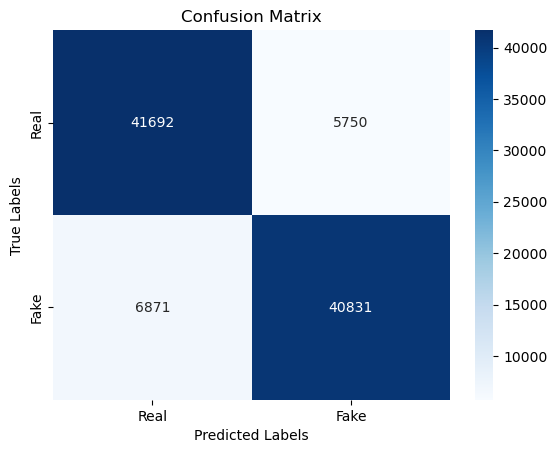

Accuracy: 0.8673484402589758
Precision: 0.8765591120843262
Recall: 0.8559599178231521
F1 score: 0.8661370554606875


In [14]:
def fen_to_features(fen):
    board_array, num_pieces = fen_to_board(fen)
    return np.concatenate((board_array, [num_pieces]))

X_real = np.array([fen_to_features(fen) for fen in real_puzzles['FEN']])
y_real = np.ones(X_real.shape[0])

X_fake = np.array([fen_to_features(fen) for fen in fake_puzzles['FEN']])
y_fake = np.zeros(X_fake.shape[0])

X = np.concatenate((X_real, X_fake))
y = np.concatenate((y_real, y_fake))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
labels = ['Real', 'Fake']
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


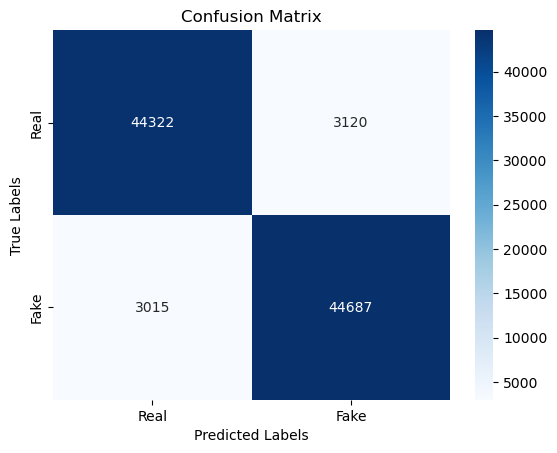

Accuracy: 0.9355187925670563
Precision: 0.9347375907293911
Recall: 0.9367951029306947
F1 Score: 0.9357652158435331


In [15]:
def fen_to_features(fen):
    board_array, num_pieces = fen_to_board(fen)
    return np.concatenate((board_array, [num_pieces]))

X_real = np.array([fen_to_features(fen) for fen in real_puzzles['FEN']])
y_real = np.ones(X_real.shape[0])

X_fake = np.array([fen_to_features(fen) for fen in fake_puzzles['FEN']])
y_fake = np.zeros(X_fake.shape[0])

X = np.concatenate((X_real, X_fake))
y = np.concatenate((y_real, y_fake))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=71)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, predictions)
# Plot the confusion matrix
labels = ['Real', 'Fake']
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [16]:
tree_depth = classifier.tree_.max_depth
print("Decision tree depth:", tree_depth)

Decision tree depth: 71


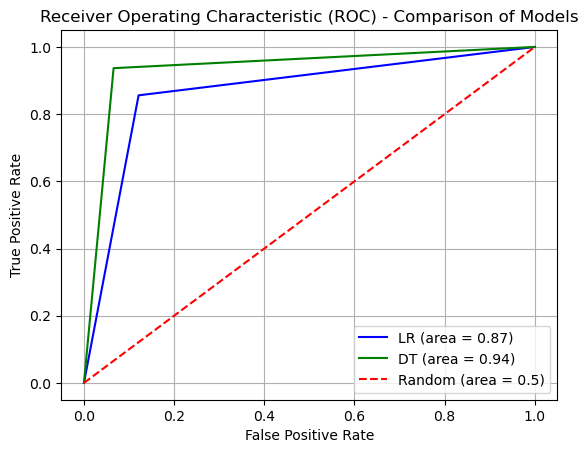

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate false positive rate and true positive rate for the first model
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Calculate false positive rate and true positive rate for the second model
fpr_2, tpr_2, _ = roc_curve(y_test, predictions)
auc_2 = roc_auc_score(y_test, predictions)

# Plot ROC curves for both models
plt.figure()
plt.plot(fpr, tpr, color='b', label='LR (area = %0.2f)' % auc)
plt.plot(fpr_2, tpr_2, color='g', label='DT (area = %0.2f)' % auc_2)
plt.plot([0, 1], [0, 1], color='r', linestyle='--', label='Random (area = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Comparison of Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


No more improvement!
The best solution found:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 12  0  3  0  7  0
  0  0  9  0  3  0  0  0  0  6  0  0  0  7  0  7  8  0  0  7  0  0  0  0
  7  7  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
Objective function:
6.0
Time:
78.01358366012573
LG: fake
DT: real
FEN:
8/ppQ5/n2p4/1K3p1p/2b1B3/2k1B1p1/8/8 w - - 0 1
Number of pieces:
13
The puzzle is a mate in 3.


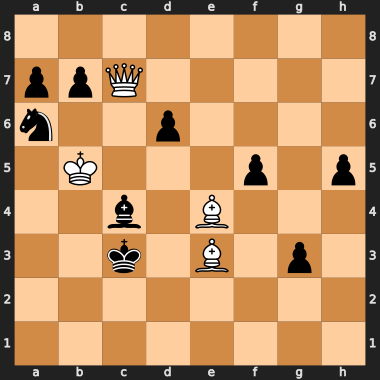

Max time per puzzle reached!
The best solution found:
[ 0  0  0  0  0  0  0  0  0  0  3  0 10  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0
  0  0  5  0  0  0  1  6 12  9  0  0  0  0  0  0]
Objective function:
0.1111111111111111
Time:
100.13302063941956
LG: fake
DT: real
FEN:
kb6/2Q3PK/8/7R/4q3/8/2B1r3/8 w - - 0 1
Number of pieces:
9
The puzzle is a mate in 3.


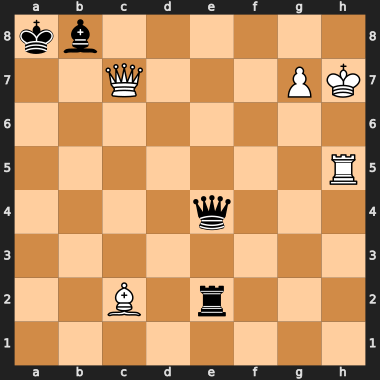

Max time per puzzle reached!
The best solution found:
[ 0  0  0  0  0  2  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 12  0  0  0  6  0 10  0  0  0  9  0  0  0  0  0  0  0
  0  0  0  0  3  9  0  0  0  4  0  0  0  0 11  5]
Objective function:
5.5
Time:
100.10451149940491
LG: fake
DT: real
FEN:
1R4qQ/4Bb2/b7/2K1r3/6k1/8/6P1/5N2 w - - 0 1
Number of pieces:
11
The puzzle is a mate in 3.


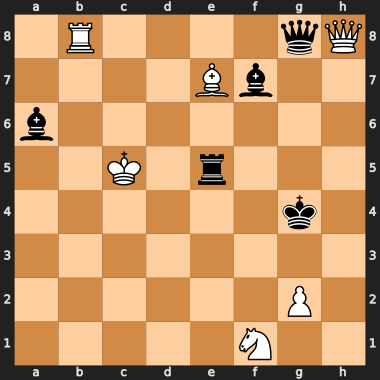

Max time per puzzle reached!
The best solution found:
[ 3  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  4  9  0  0 11  0  0
  0  0  0  0  0  0  0  0 12  3  7  0  0  0  0  0  0  9  0  0  0  8  0  0
  0  0  0  1  0  0  8  0  0  0  4  0  0  6  0  0]
Objective function:
7.0
Time:
100.08436465263367
LG: fake
DT: real
FEN:
2R2K2/3P2n1/1b3n2/kBp5/8/1Rb2q2/6r1/B7 w - - 0 1
Number of pieces:
14
The puzzle is a mate in 3.


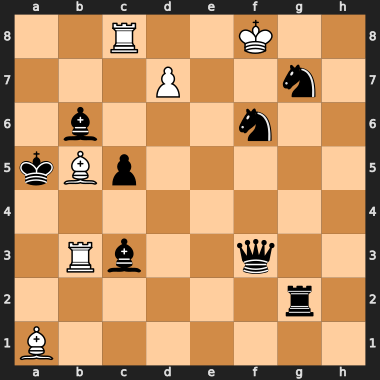

Max time per puzzle reached!
The best solution found:
[10  4  0  0  0  0  0  0 12  9  0  0  0  0  7  7  0  0  6  0  0  0  0  0
  0  0  4  0  0  0  0  0  0  0  0  0  3  0  0  0  0  2 11  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Objective function:
5.5
Time:
100.09187531471252
LG: real
DT: real
FEN:
8/8/1Nq5/4B3/2R5/2K5/kb4pp/rR6 w - - 0 1
Number of pieces:
11
The puzzle is a mate in 3.


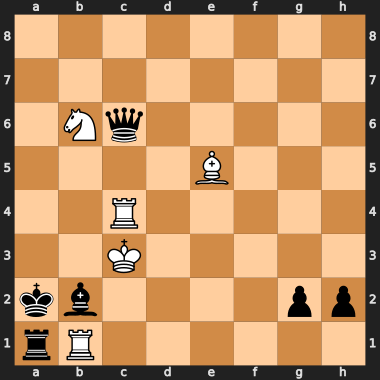

Max time per puzzle reached!
The best solution found:
[ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0 11  0  0
  0  0  0  0  0  0  9  0  6  0  0  0  0  0 12 10  0  4  0  0  0  0  0  0
  0  0  0  1  0  0  0  0  0  0  0  0  0  4  0  0]
Objective function:
0.1111111111111111
Time:
100.09895133972168
LG: fake
DT: real
FEN:
5R2/3P4/1R6/K5kr/6b1/5q2/4r3/8 w - - 0 1
Number of pieces:
9
The puzzle is a mate in 3.


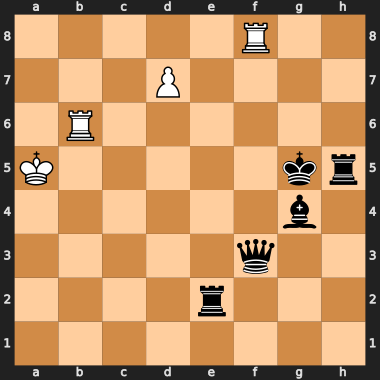

No more improvement!
The best solution found:
[ 0  0  2  0  0  0 12  0  0  0  0  0  9  0  0  4  0  0  0  0  0  0 11  0
  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  6 10  0  0  0  0  0  0  0
  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Objective function:
0.1111111111111111
Time:
79.92248702049255
LG: fake
DT: real
FEN:
8/1R6/r7/7K/7Q/6q1/4b2R/2N3k1 w - - 0 1
Number of pieces:
9
The puzzle is a mate in 3.


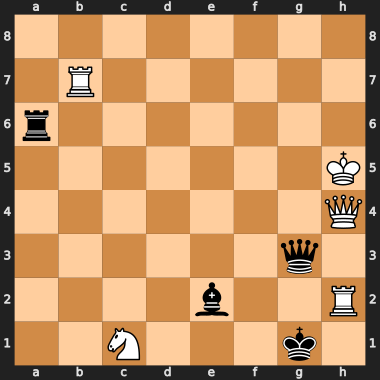

Max time per puzzle reached!
The best solution found:
[ 0  0  0  0  0  0  0  0  7  7  7  0  0  0  6  0  0  0  0  0  0  0  0  0
  0  0  4  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  7  0  0  7  7 12
  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0 10]
Objective function:
5.5
Time:
100.11976909637451
LG: real
DT: real
FEN:
7r/6P1/2p2ppk/4P3/2R5/8/ppp3K1/8 w - - 0 1
Number of pieces:
12
The puzzle is a mate in 3.


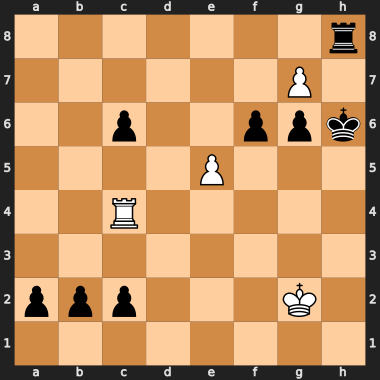

Max time per puzzle reached!
The best solution found:
[ 0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  3  0  0  6  0
  0  0  0  0  9  4  0  0  0  0  0  0  7  0  0  0  0  0  0  0 12  1  0  0
  0  0  0  1  8  0  0  0  0  0  0  5  0  0  0  0]
Objective function:
6.0
Time:
100.11670899391174
LG: fake
DT: real
FEN:
3Q4/3Pn3/4kP2/4p3/4bR2/r2B2K1/8/1q6 w - - 0 1
Number of pieces:
12
The puzzle is a mate in 3.


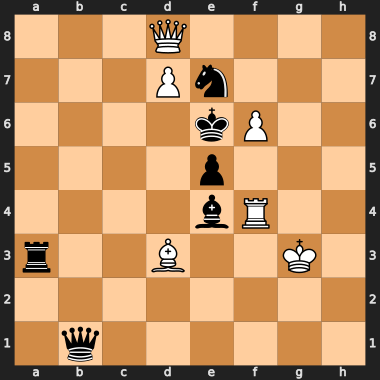

Max time per puzzle reached!
The best solution found:
[ 0  0  0  5  0  0  0 10  0  3  0  6  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0 11  0  1  4  0 12  0  0  0  0  0  9
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Objective function:
6.111111111111111
Time:
100.06928157806396
LG: fake
DT: real
FEN:
8/8/1k5b/4q1PR/8/8/1B1K4/3Q3r w - - 0 1
Number of pieces:
9
The puzzle is not a mate in 3.


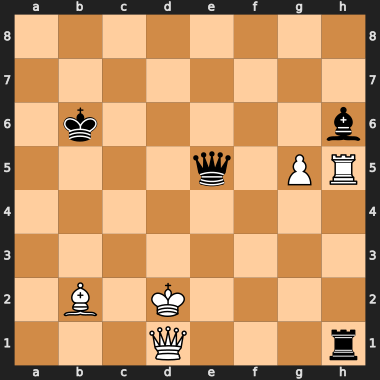

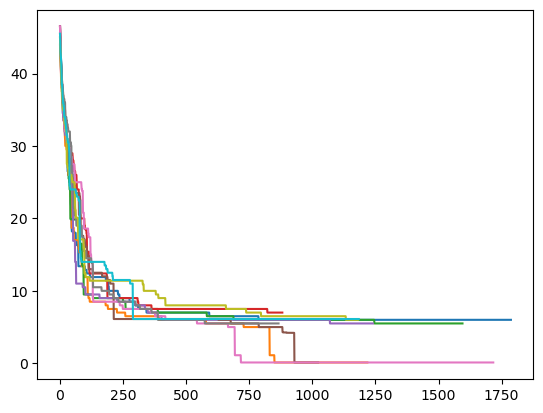

In [18]:
times = []
best_fitness = []
invalid = 0
mateIn3 = 0
Xnum = 0
for i in range(10):
    Individual.niz = []
    st = time.time()
    best_board = ga(40,4000,10,0.9,0.05,4,1000,100)
    et = time.time()
    times.append(et-st)
    best_fitness.append(best_board.fitness)
    print("Time:")
    print(et-st)
    board = best_board.array_to_board(best_board.code)
    prediction = clf.predict(np.concatenate((best_board.code, [len(board.piece_map())])).reshape(1, -1))
    print("LG: real" if prediction else "LG: fake")
    prediction = classifier.predict(np.concatenate((best_board.code, [len(board.piece_map())])).reshape(1, -1))
    print("DT: real" if prediction else "DT: fake")
    print("FEN:")
    print(board.fen())
    print("Number of pieces:")
    print(len(board.piece_map()))
    
    
    if board.is_valid():
        
        info = engine.analyse(board, chess.engine.Limit(depth=10), multipv=2)

        # Check if the puzzle is mate in 3
        score = info[0]["score"].white()
        if score.is_mate() and score.mate() == 3:
            print("The puzzle is a mate in 3.")
            mateIn3 += 1
            if len(board.piece_map()) == 9:
                Xnum += 1
        else:
            print("The puzzle is not a mate in 3.")
    else:
        print("Invalid board")
        invalid += 1
        
    # Display the board
    svg = chess.svg.board(board=board, size=380)
    display(SVG(svg))

Invalid boards: 0
Mate in 3 puzzles: 9
Mate in 3 puzzles that have x number of pieces: 3


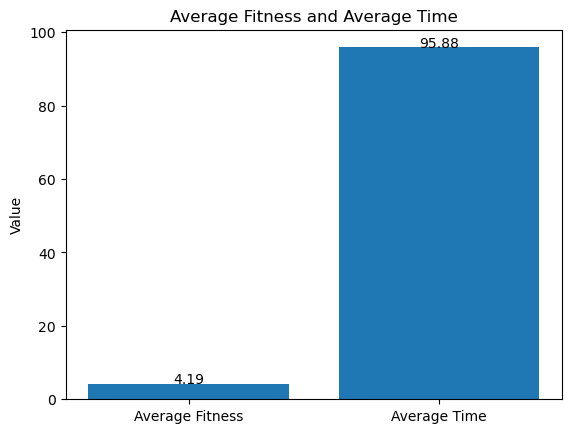

[78.01358366012573, 100.13302063941956, 100.10451149940491, 100.08436465263367, 100.09187531471252, 100.09895133972168, 79.92248702049255, 100.11976909637451, 100.11670899391174, 100.06928157806396] [6.0, 0.1111111111111111, 5.5, 7.0, 5.5, 0.1111111111111111, 0.1111111111111111, 5.5, 6.0, 6.111111111111111]


In [20]:
avg_fitness = np.mean(best_fitness)
avg_time = np.mean(times)

print('Invalid boards:',invalid)
print('Mate in 3 puzzles:',mateIn3)
print('Mate in 3 puzzles that have x number of pieces:',Xnum)
plt.bar(['Average Fitness', 'Average Time'], [avg_fitness, avg_time])
plt.text(0, avg_fitness + 0.1, f'{avg_fitness:.2f}', ha='center')
plt.text(1, avg_time + 0.1, f'{avg_time:.2f}', ha='center')
plt.ylabel('Value')
plt.title('Average Fitness and Average Time')

plt.show()
print(times, best_fitness)